In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import maxabs_scale


from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.stem import WordNetLemmatizer

from scipy.sparse import csr_matrix
from scipy.sparse import hstack

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
print(train.shape, test.shape)

(7613, 5) (3263, 4)


In [4]:
combined_data = pd.concat([train.drop(['target', 'id'] , axis=1), test.drop(['id'] , axis=1)], ignore_index=True)

In [5]:
def pre_process_text(df):

    # Remove URLs
    url_pattern = r'http\S+|www.\S+'
    df = df.str.replace(url_pattern, '', regex=True)

    # Remove mention pattern
    mention_pattern = r'@\w+'
    df = df.str.replace(mention_pattern, '', regex=True)

    # Remove HTML Tags
    html_pattern = r'<.*?>'
    df = df.str.replace(html_pattern, '', regex=True)

    #Remove Emoticons
    emoticons_pattern = re.compile("["
                     u"\U0001F600-\U0001F64F"  # emoticons
                     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                     u"\U0001F680-\U0001F6FF"  # transport & map symbols
                     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     "]+", flags=re.UNICODE)
    
    df= df.str.replace(emoticons_pattern, '')

    # Remove special chars
    df = df.str.replace(r'[^\w\s]', '', regex = True)

    # To Lower case
    df = df.str.lower()

    # Tokenize & remove stopwords
    stop_words = set(stopwords.words('english'))
    df =df.apply(lambda x : ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

    return df

In [6]:
missing_percent = ((combined_data.isnull().sum()/combined_data.shape[0])*100).reset_index()

missing_percent.columns =['Column' , 'Percentage']

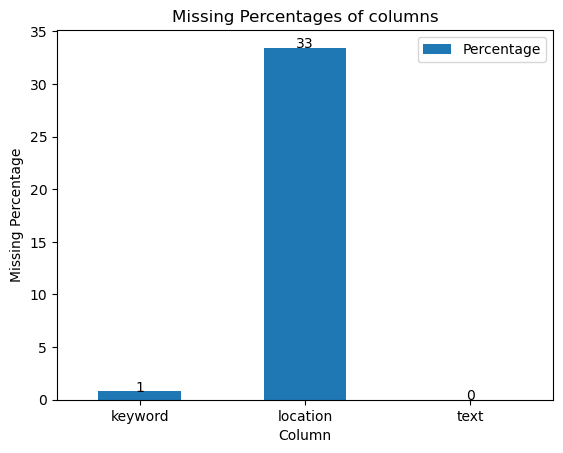

In [7]:
missing_percent.plot.bar(x='Column', y='Percentage' , rot=0)

mpl.pyplot.xlabel("Column")
mpl.pyplot.ylabel("Missing Percentage")
mpl.pyplot.title("Missing Percentages of columns")

for i, v in enumerate(missing_percent.Percentage):
    mpl.pyplot.text(i, v, str(round(v)), ha='center', va = 'baseline')

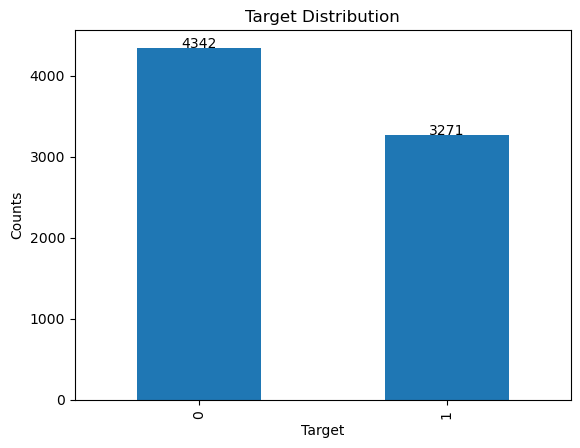

In [8]:
train.target.value_counts().plot.bar()
mpl.pyplot.xlabel("Target")
mpl.pyplot.ylabel("Counts")
mpl.pyplot.title("Target Distribution")

for i, v in enumerate(train.target.value_counts().values):
    mpl.pyplot.text(i, v, str(v), ha='center', va = 'baseline')

In [9]:
null_cols = combined_data.columns[combined_data.isnull().any()]
combined_data[null_cols] = combined_data[null_cols].fillna('missing')

In [10]:
combined_data.keyword = combined_data.keyword.str.replace('%20', ' ')
combined_data['keyword_new']= pre_process_text(combined_data.keyword)
combined_data['location_new']= pre_process_text(combined_data.location)
combined_data['text_new'] = pre_process_text(combined_data.text)


In [11]:
train['keyword' ] = combined_data['keyword_new'][:7613,]
train['location' ] = combined_data['location_new'][:7613,]

In [12]:
pivote_table = train.pivot_table(index = 'target', columns='keyword' , values='id' , aggfunc=len)
pivote_table = pivote_table.fillna(0)

pivote_table = pivote_table.transpose()

pivote_table.columns = ['not_disaster' , 'disaster']

In [13]:
pivote_table['percent_disaster'] = (pivote_table['disaster']/(pivote_table['not_disaster'] + pivote_table['disaster']))*100
pivote_table['percent_not_disaster'] = (pivote_table['not_disaster']/(pivote_table['not_disaster'] + pivote_table['disaster']))*100

In [14]:
combined_data['percent_disaster'] = combined_data['keyword_new'].map(pivote_table['percent_disaster'])

In [15]:
pivote_table2 = train.pivot_table(index = 'target', columns='location' , values='id' , aggfunc=len)
pivote_table2 = pivote_table2.fillna(0)

pivote_table2 = pivote_table2.transpose()
pivote_table2.columns = ['not_disaster' , 'disaster']

# Lemmatization

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    token_words = nltk.word_tokenize(sentence)
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(w) for w in token_words])
    return lemmatized_sentence

In [17]:
combined_data['lemmatized_text'] = combined_data['text_new'].apply(lambda x:lemmatize_sentence(x))

# Stemming

In [18]:
ps = PorterStemmer()

def stem_sentence(sentence):
    token_words = nltk.word_tokenize(sentence)
    stemed_sentence = ' '.join([ps.stem(w) for w in token_words])
    return stemed_sentence

combined_data['stemed_text'] = combined_data['lemmatized_text'].apply(lambda x:stem_sentence(x))

In [19]:
#TFIDF

vectorizer = TfidfVectorizer(ngram_range=(2,3))

vectorizer.fit(combined_data.stemed_text)

X= vectorizer.transform(combined_data.stemed_text)

y_train = train.target

In [20]:
vectorizer.get_feature_names_out().shape

(120672,)

In [21]:
y_train.shape

(7613,)

In [22]:
#X = csr_matrix(hstack([X,keywords]))

In [23]:
#maxabs_scale(X,copy=False)

In [24]:
X_train = X[:7613,]

In [25]:
X_train.shape

(7613, 120672)

In [26]:
X_test = X[7613:,]

In [ ]:
#svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

#svd.fit(X_train)

#X_train = svd.transform(X_train)

#X_test = svd.transform(X_test)

# MLPClassifier

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000 , solver='lbfgs').fit(X_train, y_train)

In [ ]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
print(classification_report(y_train, predict_train))

In [ ]:
submission = pd.DataFrame(test['id'] , columns=['id'])

In [ ]:
submission['target'] = predict_test

In [ ]:
submission.to_csv('submission.csv' , index=False)

# Multinomial Naive Bayes Classifier

In [27]:
clf = MultinomialNB()

param_grid = {'alpha': [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1,2,3,4,5,6,7,8,9, 10]}

grid = GridSearchCV(clf, param_grid, cv=5, scoring = 'recall')

grid.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='recall')

In [28]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.01}
0.8593883792048931


In [29]:
clf = MultinomialNB(alpha=0.01).fit(X_train,y_train)

In [30]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [31]:
print(classification_report(y_train, predict_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4342
           1       0.98      0.98      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613



In [32]:
submission = pd.DataFrame(test['id'] , columns=['id'])
submission['target'] = predict_test
submission.to_csv('submission.csv' , index=False)

# LogisticRegression

In [ ]:
#clf = LogisticRegression(random_state=42, solver= 'liblinear' , class_weight = 'balanced', max_iter=10000
#                            ).fit(X_train, y_train)

In [ ]:
#grid_values = {'penalty' : ['l1', 'l2'] ,'C':[0.001,0.009,0.01,.09,1]}

#grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')

#grid_clf_acc.fit(X_train, y_train)

# Decision tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

grid_values = {'max_depth' : list(range(10,30,5)) , 'criterion' : ['gini' , 'entropy']}

clf = GridSearchCV(dt, grid_values, cv = 10, scoring='accuracy')

clf.fit(X_train, y_train)

print(clf.best_params_)

print(clf.best_score_)


In [ ]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
print(classification_report(y_train, predict_train))

# randomforrest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=50, random_state=42)

grid_values = {'max_depth' : list(range(10,30,5)) , 'criterion' : ['gini' , 'entropy']}

clf = GridSearchCV(rf, grid_values, cv = 10, scoring='accuracy')

clf.fit(X_train, y_train)

print(clf.best_params_)

print(clf.best_score_)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

print(classification_report(y_train, predict_train))